In [1]:
# Author: Robert Guthrie

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import math

torch.manual_seed(1)

In [6]:
from sklearn.model_selection import train_test_split

In [2]:
lin = nn.Linear(5, 3)  # maps from R^5 to R^3, parameters A, b
# data is 2x5.  A maps from 5 to 3... can we map "data" under A?
data = torch.randn(2, 5)
print(lin(data))  # yes

tensor([[ 0.1755, -0.3268, -0.5069],
        [-0.6602,  0.2260,  0.1089]], grad_fn=<AddmmBackward0>)


In [15]:
# In pytorch, most non-linearities are in torch.functional (we have it imported as F)
# Note that non-linearites typically don't have parameters like affine maps do.
# That is, they don't have weights that are updated during training.
data = torch.randn(2, 2)
print(data)
print(F.relu(data))

tensor([[ 0.0581,  0.8505],
        [-1.0904, -0.1089]])
tensor([[0.0581, 0.8505],
        [0.0000, 0.0000]])


In [25]:
torch.get_num_threads()

4

In [2]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(1, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1),
      nn.ReLU()
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [17]:
X = np.concatenate((np.linspace(0.5, 200, 500), np.linspace(400,600,500), np.linspace(800,1000,500)), axis=0)
Y = []
for i in X:
    Y.append(math.sqrt(i))
X = np.array(X).reshape(-1,1)
Y = np.array(Y)

In [18]:
indices = np.random.permutation(len(X))

# Shuffle X and Y using the permutation
X = X[indices]
Y = Y[indices]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [8]:
class SqrtDataset(torch.utils.data.Dataset):
  '''
  Prepare the Poly dataset for regression
  '''

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [25]:
dataset = SqrtDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

In [21]:
def mape_loss(output, target):
    epsilon = 1e-6  # To avoid division by zero
    abs_diff = torch.abs(target - output)
    percentage_error = abs_diff / (torch.abs(target) + epsilon)
    return torch.mean(percentage_error) * 100

In [38]:
mlp = MLP()
  
# Define the loss function and optimizer
loss_function = mape_loss #nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

In [39]:
for epoch in range(0, 500): # 5 epochs at maximum
    # Print epoch
    #print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      targets = targets.reshape((targets.shape[0], 1))
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets)
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if epoch%10 == 0 and i> 0 and i % 210 == 0:
          print('epoch: %d, Loss after mini-batch %5d: %.3f' %
                (epoch, i + 1, current_loss/(i+1)))
          current_loss = 0.0

epoch: 0, Loss after mini-batch   211: 34.075
epoch: 10, Loss after mini-batch   211: 9.410
epoch: 20, Loss after mini-batch   211: 6.393
epoch: 30, Loss after mini-batch   211: 5.223
epoch: 40, Loss after mini-batch   211: 4.809
epoch: 50, Loss after mini-batch   211: 2.916
epoch: 60, Loss after mini-batch   211: 3.345
epoch: 70, Loss after mini-batch   211: 2.866
epoch: 80, Loss after mini-batch   211: 2.835
epoch: 90, Loss after mini-batch   211: 2.950
epoch: 100, Loss after mini-batch   211: 2.315
epoch: 110, Loss after mini-batch   211: 2.145
epoch: 120, Loss after mini-batch   211: 1.665
epoch: 130, Loss after mini-batch   211: 2.015
epoch: 140, Loss after mini-batch   211: 2.331
epoch: 150, Loss after mini-batch   211: 1.937
epoch: 160, Loss after mini-batch   211: 1.718
epoch: 170, Loss after mini-batch   211: 1.384
epoch: 180, Loss after mini-batch   211: 1.615
epoch: 190, Loss after mini-batch   211: 1.498
epoch: 200, Loss after mini-batch   211: 1.773
epoch: 210, Loss after 

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [41]:
y_pred = mlp(torch.from_numpy(X_test.reshape(-1,1)).float()).detach().cpu().numpy()
rmse = mean_squared_error(y_test.ravel(), y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test.ravel(), y_pred)
print(rmse, mape)

0.1507408842813203 0.005812637149984108


c:\Users\mmayur\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [93]:
m = nn.ELU()
input = torch.randn(2)
output = m(input)

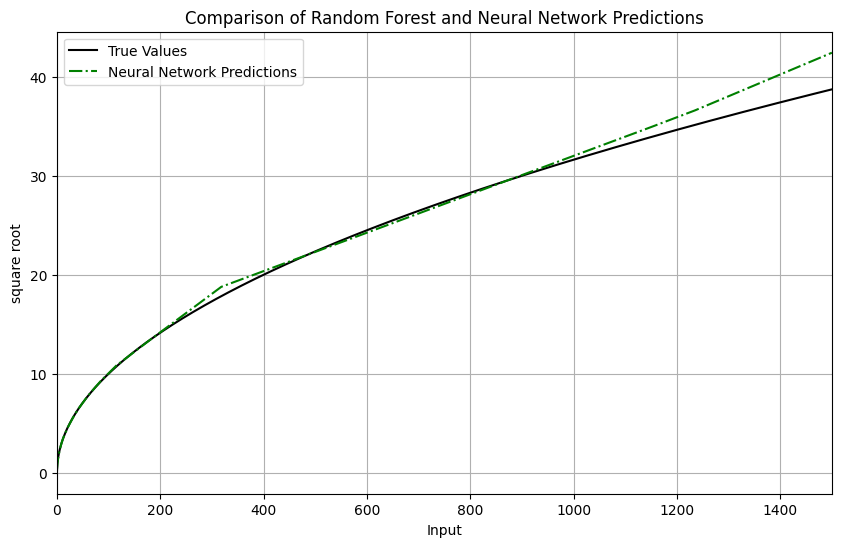

In [42]:
import matplotlib.pyplot as plt

# Example data
X_actual = np.linspace(0, 1500, 1500)
Y_actual = [math.sqrt(i) for i in X_actual]
Y_pred_nn = mlp(torch.from_numpy(X_actual.reshape(-1,1)).float()).detach().cpu().numpy() # Predictions from neural network

# Plot
plt.figure(figsize=(10, 6))

# Plot true values
plt.plot(X_actual, Y_actual, color='black', linestyle='-', label='True Values')

# Plot Neural Network predictions
plt.plot(X_actual, Y_pred_nn, color='green', linestyle='-.', label='Neural Network Predictions')

# Add labels and title
plt.xlabel('Input')
plt.xlim(0,1500)
plt.ylabel('square root')
plt.title('Comparison of Random Forest and Neural Network Predictions')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [55]:
w

tensor([[ 1.9789,  0.1590,  0.4247],
        [ 0.4838,  0.4704, -0.0130],
        [ 0.0532, -0.2879,  0.1510],
        [-0.3888, -0.5611,  0.5687],
        [ 1.5684,  0.5698, -0.9451]], requires_grad=True)

In [67]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [70]:
w,b,x

(tensor([[ 1.7031,  0.8448, -0.0265],
         [ 0.5622,  1.0879,  0.8217],
         [ 0.5258,  1.0627,  0.2446],
         [-0.2436, -1.3045, -0.9276],
         [ 1.0536, -3.0057, -0.0083]], requires_grad=True),
 tensor([-0.1723, -1.5460,  0.3543], requires_grad=True),
 tensor([1., 1., 1., 1., 1.]))

In [74]:
torch.get_num_threads()

4

In [77]:
torch.cuda.device_count()

0

In [65]:
w,b

(tensor([[-0.5746, -0.4133,  0.1847],
         [ 0.3519, -0.1045,  0.4480],
         [ 0.5578,  0.9765,  0.2809],
         [ 0.6761, -0.0571, -1.0737],
         [-0.3899,  0.4127, -0.9545]], requires_grad=True),
 tensor([ 0.9459, -0.9490,  1.2247], requires_grad=True))

In [60]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x000001D87163E700>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000001D87163E190>


In [66]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2758, 0.1555, 0.1758],
        [0.2758, 0.1555, 0.1758],
        [0.2758, 0.1555, 0.1758],
        [0.2758, 0.1555, 0.1758],
        [0.2758, 0.1555, 0.1758]])
tensor([0.2758, 0.1555, 0.1758])


In [45]:
x = torch.tensor([1.], requires_grad=True)
with torch.no_grad():
    y = x * 2
print(x)
print(x,y)

tensor([1.], requires_grad=True)
tensor([1.], requires_grad=True) tensor([2.])


In [46]:
y.requires_grad
@torch.no_grad()
def doubler(x):
    return x * 2
z = doubler(x)
z.requires_grad
# @torch.no_grad
# def tripler(x):
#     return x * 3
# z = tripler(x)
# z.requires_grad
# # factory function exception
# with torch.no_grad():
#     a = torch.nn.Parameter(torch.rand(10))
# a.requires_grad

False